#import libraries

In [ ]:
!pip install skope-rules
!pip install eli5
!pip install scikit-plot

     |████████████████████████████████| 106 kB 9.2 MB/s 


In [ ]:
!pip install dalex
!pip install lime

     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 38.1 MB 293 kB/s 
  Created wheel for dalex: filename=dalex-1.4.1-py3-none-any.whl size=1042860 sha256=c19e679940fd20d193112fbcd55207db1179e2cca6416f50628bcbcb7f1a65cf
  Stored in directory: /root/.cache/pip/wheels/8c/8e/1b/95d59374d386e8e495aed6cbab4c4b6d72be73993a424c5e12
Successfully built dalex
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 275 kB 9.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=8aa1a50f821eab91c5678bef209752b183bf3

In [ ]:
import pandas as pd
import numpy as np
# load scikit-plot modules
import scikitplot as skplt
# import matplotlib.pyplot module for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# import train and test split method from scikit-learn
from sklearn.model_selection import train_test_split
# import metrics method for model evaluation
import sklearn.metrics as metrics
# load linear regression model
from sklearn.linear_model import LinearRegression
# load logistic regression model
from sklearn.linear_model import LogisticRegression
# load decision tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
# load tree visualization
from sklearn.tree import plot_tree, export_text

# load statsmodel module 
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import dalex to explain complex model
import dalex as dx

# load LimeTabularExplainer for LIME method
from lime.lime_tabular import LimeTabularExplainer 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
raw = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/car_insurance_fraud_dataset/insuranceFraud.csv", sep= ',')

In [ ]:
raw.shape

(1000, 39)

In [ ]:
raw.shape

(1000, 39)

In [ ]:
num_var = raw.select_dtypes(include = 'number').columns

# no 1. check null data


In [ ]:
raw.loc[raw["umbrella_limit"]<0]

months_as_customer  age  policy_number policy_bind_date policy_state  \
290                 284   42         526039         5/4/1995           OH   

    policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
290    100/300                500                1338.54        -1000000   

     insured_zip  ... witnesses police_report_available total_claim_amount  \
290       438178  ...         1                       ?              94160   

    injury_claim property_claim  vehicle_claim  auto_make auto_model  \
290         8560          17120          68480  Chevrolet     Malibu   

    auto_year fraud_reported  
290      1996              N  

[1 rows x 39 columns]

There is one missing value for column umbrella_limit in row 290 because it is impossible for umbrella_limit to be less than **zero**

```
# This is formatted as code
```



In [ ]:
cat_var = raw.select_dtypes(include = 'object').columns

In [ ]:
i=1
missing_cat = list()
for col in cat_var:
  missing = len(raw.loc[raw[col]=="?"])
  if  missing == 0:
    continue
  else:
    missing_cat.append(col)
    print(str(i)+". column name with missing value: "+col)
    print(str(missing) +" rows")
    i+=1

1. column name with missing value: collision_type
178 rows
2. column name with missing value: property_damage
360 rows
3. column name with missing value: police_report_available
343 rows


there are 3 non-numerical columns with missing values, as shown in above:


1.  column name with missing value: collision_type with
178 missing rows
2. column name with missing value: property_damage with
360 missing rows
3. column name with missing value: police_report_available with
343 missing rows




#no 2. handling missing values

check distribution for missing values on each fraud category

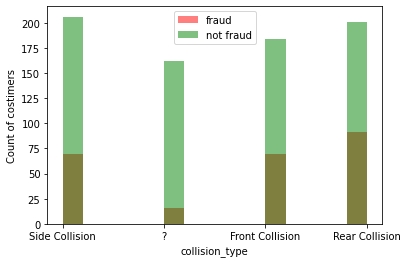

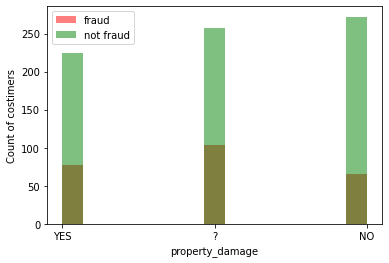

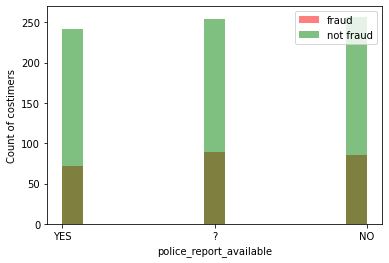

In [ ]:
#plotting missing variables
for x_col in missing_cat : 
    fig, ax = plt.subplots()

    ax.hist(raw[raw["fraud_reported"]=="Y"][x_col], bins=15, alpha=0.5, color="red", label="fraud")
    ax.hist(raw[raw["fraud_reported"]=="N"][x_col], bins=15, alpha=0.5, color="green", label="not fraud")
    ax.set_xlabel(x_col)
    ax.set_ylabel("Count of costimers")
    ax.legend();

Based on these EDA, we can treat these missing values differently for each column: 


1.   for collision type, only minority of rows with missing values are reported a fraud case, hence we can simply drop these rows
2.   for police report, the number of reported fraud cases with missing police report is bigger then with/without police report. based on this We can hypothesize that these culprit does not want to report their case to police to avoid the risk of being caught. hence, we can treat these missing with no police report. However, to avoid bias towards the actual not reported fraud case without police report, then we can add more column to introduce some weight/importance to non-imputed and imputed observations.
3.  same case with police report, we can treat these missing property damage with no property damage. However, to avoid bias towards the actual not reported fraud case without property damage, then we can add more column to introduce some weight/importance to non-imputed and imputed observations.



In [ ]:
raw_backup = raw.copy()

In [ ]:
raw["police_report_available"] = raw["police_report_available"].replace("?","no_imputed")
raw["imputed_police_report"] = raw["police_report_available"].apply(lambda x: 1 if x == "no_imputed" else 0)
raw["police_report_available"] = raw["police_report_available"].replace("no_imputed","NO")

In [ ]:
raw["property_damage"] = raw["property_damage"].replace("?","no_imputed")
raw["imputed_property_damage"] = raw["property_damage"].apply(lambda x: 1 if x == "no_imputed" else 0)
raw["property_damage"] = raw["property_damage"].replace("no_imputed","NO")

In [ ]:
raw = raw.replace("?",np.nan)

In [ ]:
raw_imputed = raw.dropna()

last, dropping rows with umbrella_limit < 0

In [ ]:
raw_imputed = raw_imputed.loc[raw_imputed["umbrella_limit"]>=0]

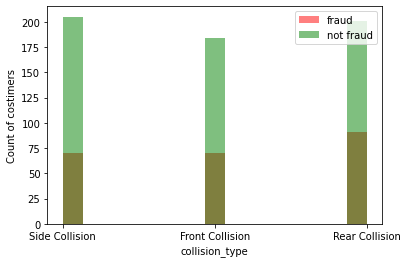

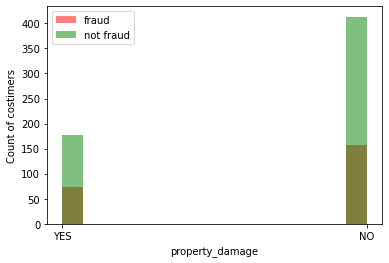

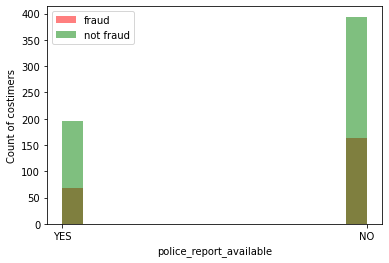

In [ ]:
#plotting missing variables after imputation
for x_col in missing_cat : 
    fig, ax = plt.subplots()

    ax.hist(raw_imputed[raw_imputed["fraud_reported"]=="Y"][x_col], bins=15, alpha=0.5, color="red", label="fraud")
    ax.hist(raw_imputed[raw_imputed["fraud_reported"]=="N"][x_col], bins=15, alpha=0.5, color="green", label="not fraud")
    ax.set_xlabel(x_col)
    ax.set_ylabel("Count of costimers")
    ax.legend();

#no 3. EDA

## check correlation

In [ ]:
raw_imputed["fraud_reported"].value_counts()

N    590
Y    231
Name: fraud_reported, dtype: int64

In [ ]:
def matrix_to_xy(df, columns=None, reset_index=False):
    bool_index = np.triu(np.ones(df.shape)).astype(bool)
    xy = (
        df.where(bool_index).stack().reset_index()
        if reset_index
        else df.where(bool_index).stack()
    )
    if reset_index:
        xy.columns = columns or ["row", "col", "val"]
    return xy


def xy_to_matrix(xy):
    df = xy.pivot(*xy.columns).fillna(0)
    df_vals = df.to_numpy()
    df = pd.DataFrame(
        np.triu(df_vals, 1) + df_vals.T, index=df.index, columns=df.index
    )
    return df
df = raw_imputed.corr()

#print(df)
xy = matrix_to_xy(df, reset_index=True)
print(xy)
#mx = xy_to_matrix(xy)
#print(mx)

                         row                      col       val
0         months_as_customer       months_as_customer  1.000000
1         months_as_customer                      age  0.924129
2         months_as_customer            policy_number  0.057979
3         months_as_customer        policy_deductable  0.028253
4         months_as_customer    policy_annual_premium  0.008839
..                       ...                      ...       ...
205                auto_year    imputed_police_report  0.021435
206                auto_year  imputed_property_damage  0.035805
207    imputed_police_report    imputed_police_report  1.000000
208    imputed_police_report  imputed_property_damage -0.007776
209  imputed_property_damage  imputed_property_damage  1.000000

[210 rows x 3 columns]


In [ ]:
xy["abs_val"]= abs(xy["val"])

In [ ]:
xy.loc[(xy["abs_val"]>=0.2) & (xy["abs_val"]!=1)]

row             col       val   abs_val
1    months_as_customer             age  0.924129  0.924129
183  total_claim_amount    injury_claim  0.645706  0.645706
184  total_claim_amount  property_claim  0.650057  0.650057
185  total_claim_amount   vehicle_claim  0.942265  0.942265
190        injury_claim  property_claim  0.263627  0.263627
191        injury_claim   vehicle_claim  0.450662  0.450662
196      property_claim   vehicle_claim  0.461898  0.461898

based on this corr table, we can drop injury claim, property_claim, vehicle_claim, and months_as_customer



## visualisation

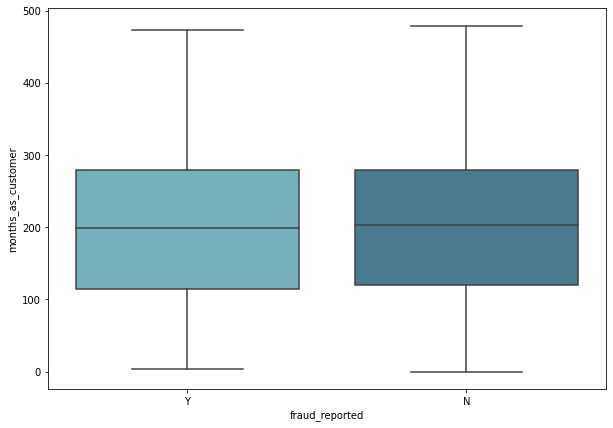

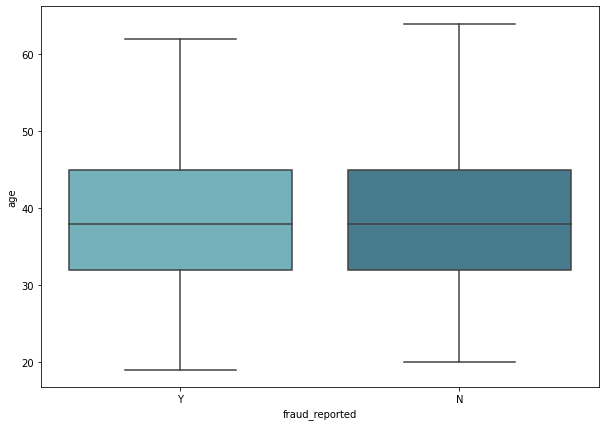

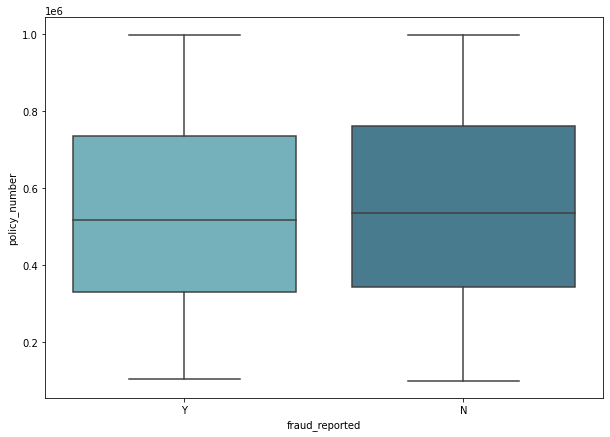

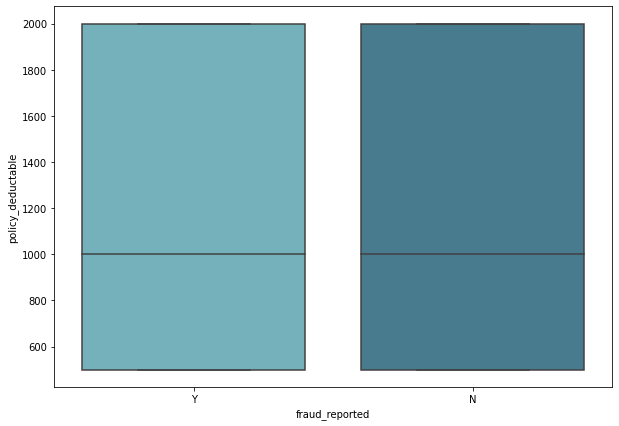

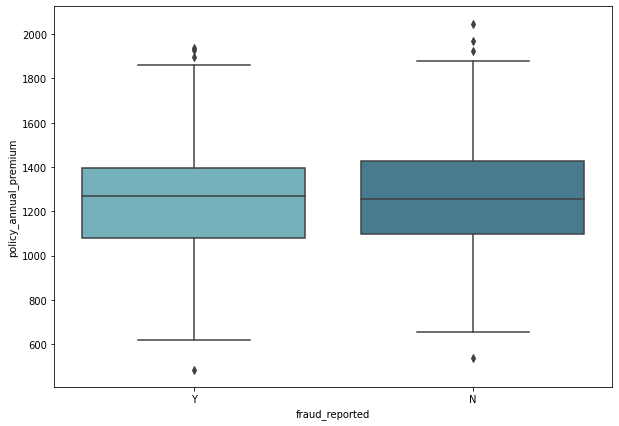

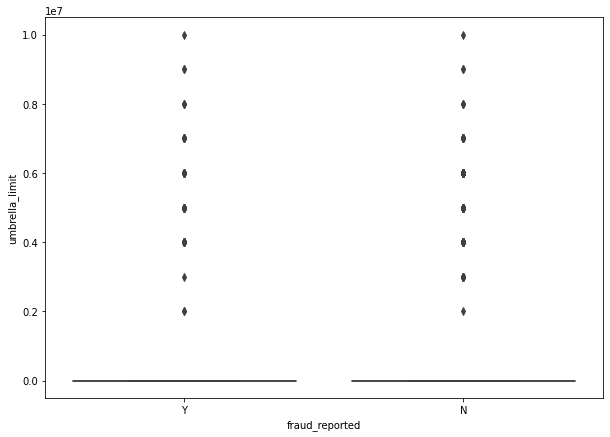

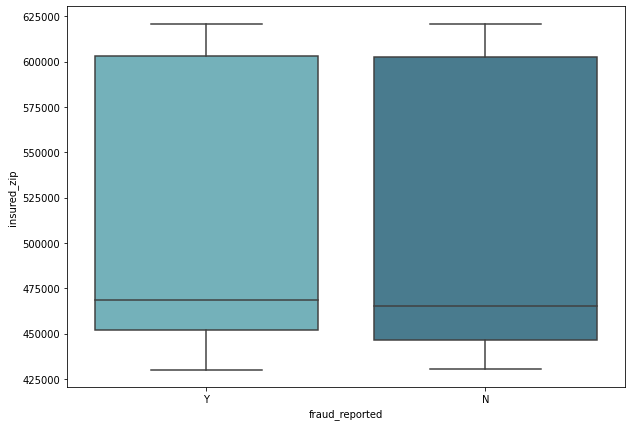

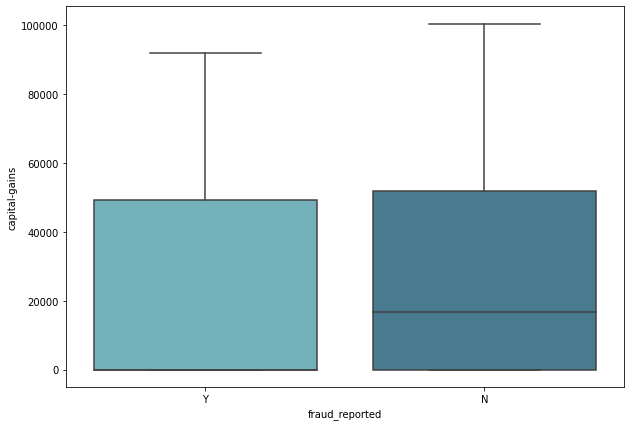

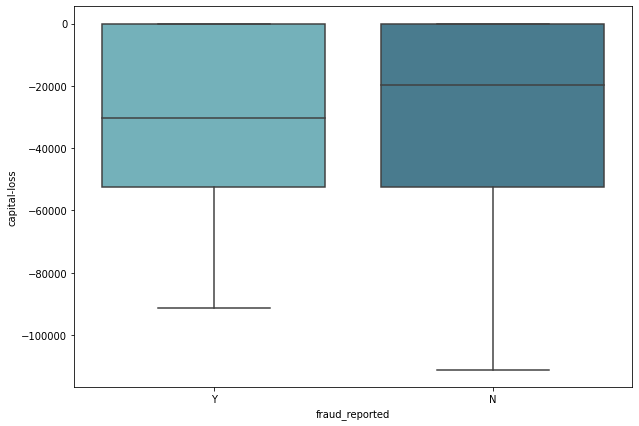

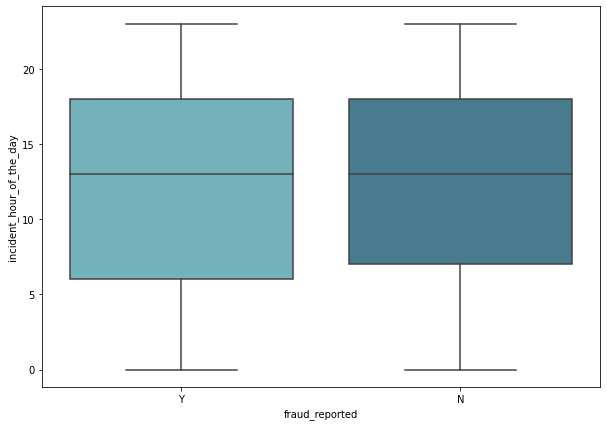

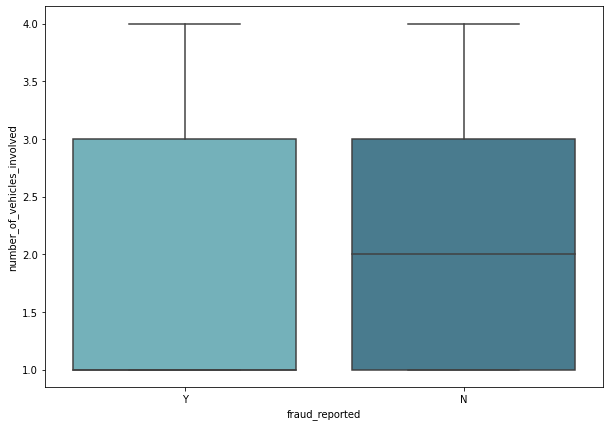

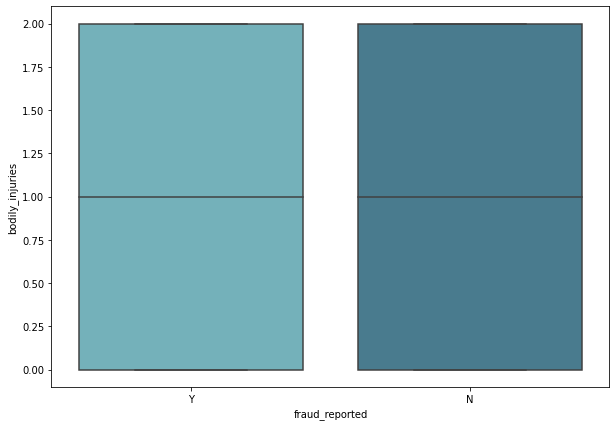

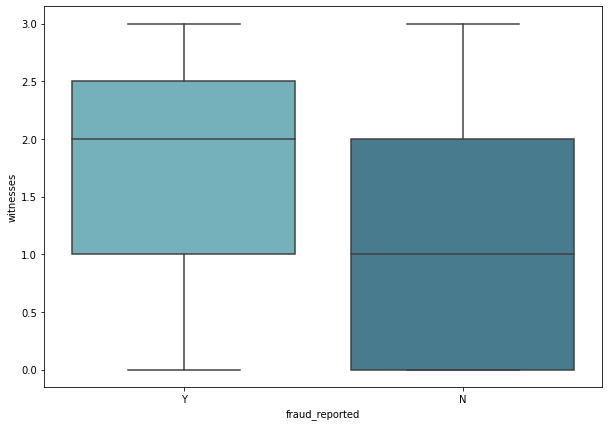

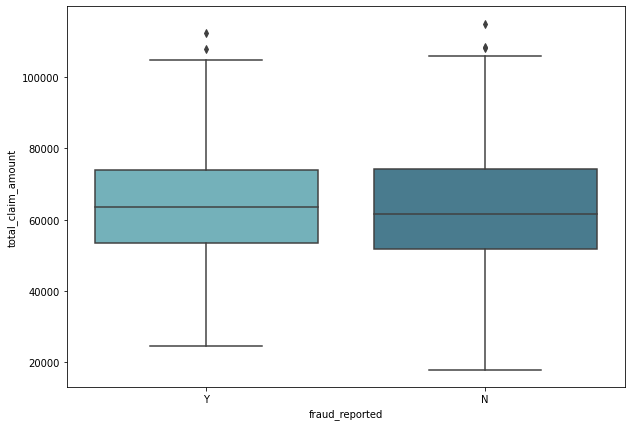

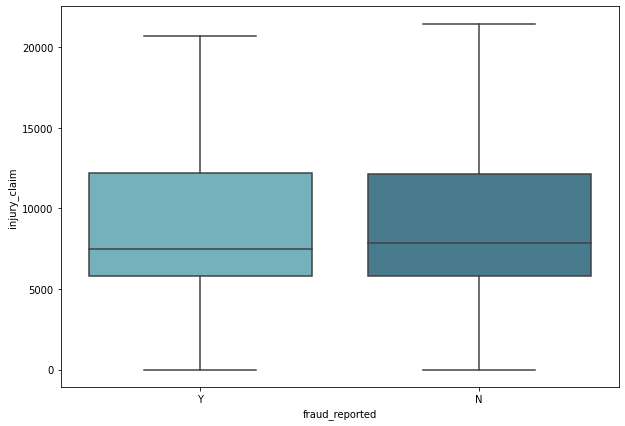

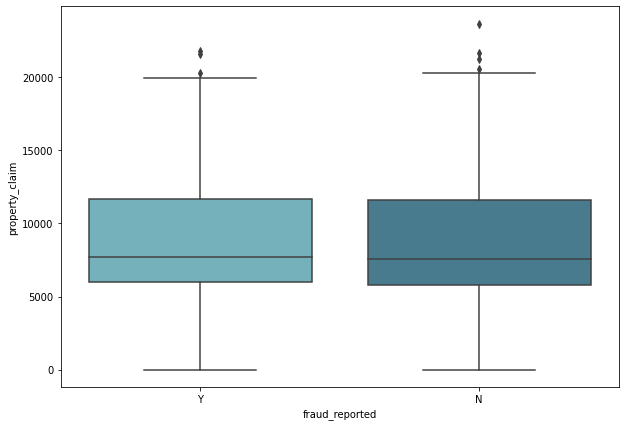

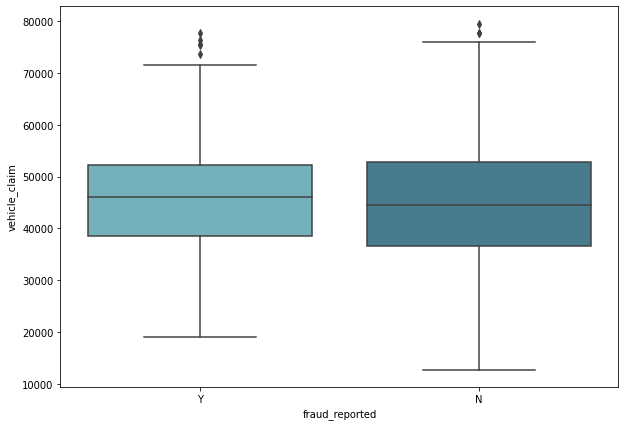

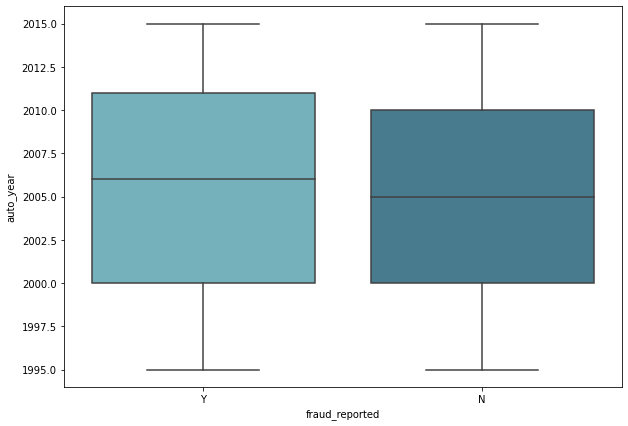

In [ ]:
for x_col in num_var:
    plt.figure(figsize = (10,7))
    sns.boxplot(x = "fraud_reported", y=x_col, data = raw_imputed, palette= 'GnBu_d')
    plt.show()

Based on this plot, we can see that some variables have similar median for two groups of fraud case. Thus, we select only variables who have different median between fraud vs non fraud cases. These are witnesses, number_of_vehicle_reported, capital_loss,capital_gain,auto_year

In [ ]:
#change auto_year to object to handle it as year, not a numeric
raw_imputed["auto_year"] = raw_imputed["auto_year"].astype(object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


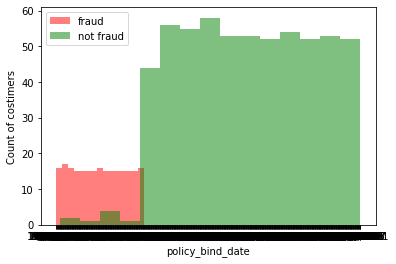

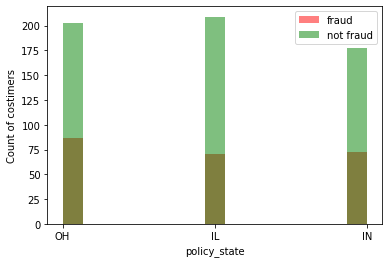

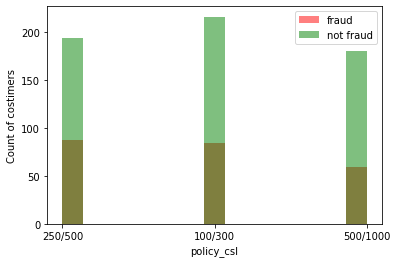

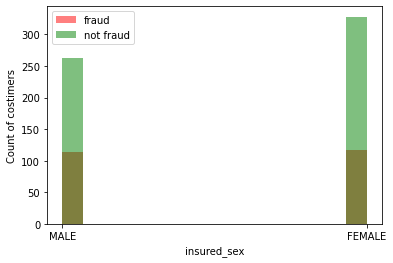

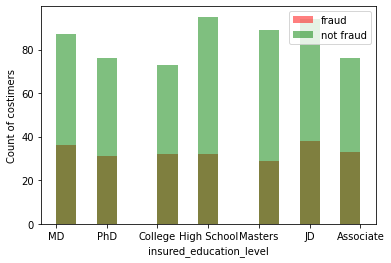

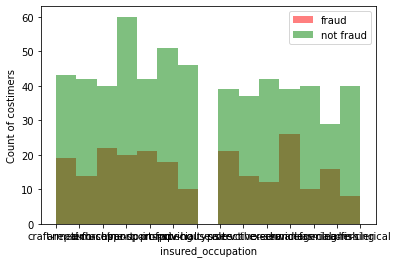

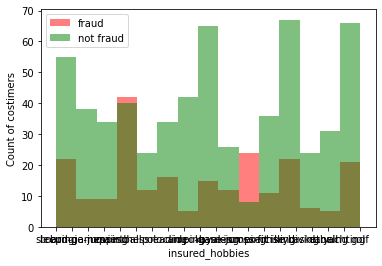

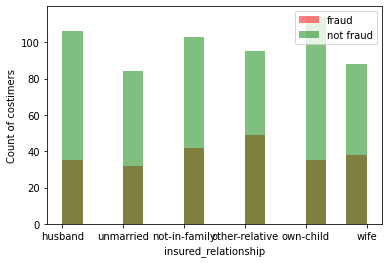

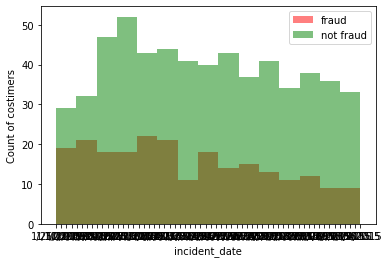

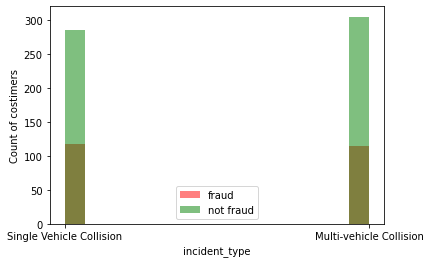

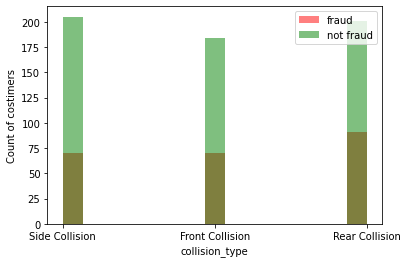

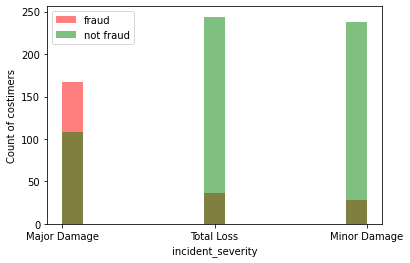

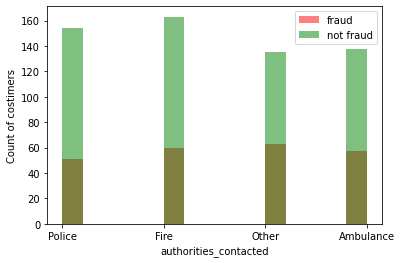

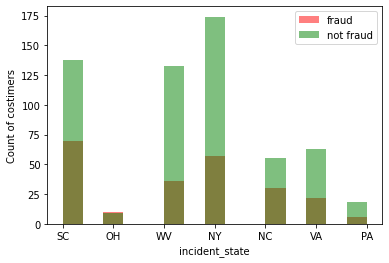

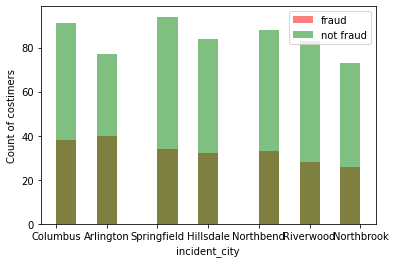

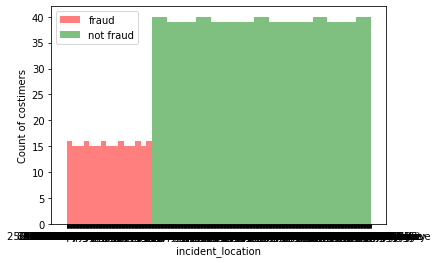

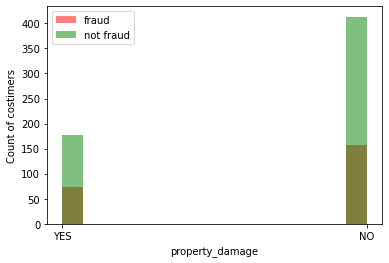

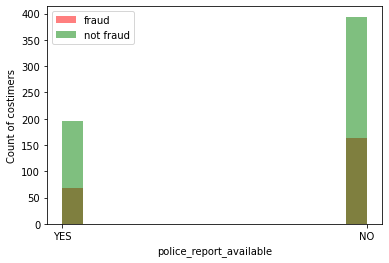

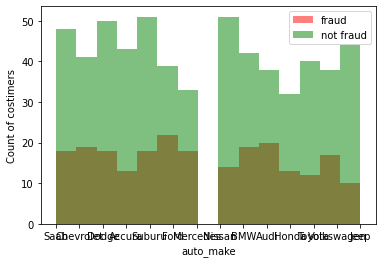

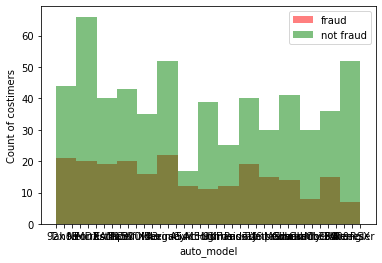

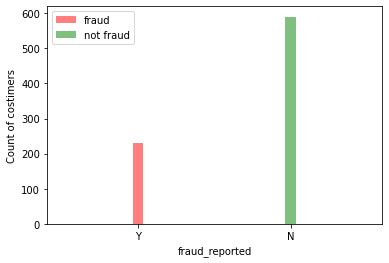

In [ ]:
#plotting categories variables 
for x_col in cat_var : 
    fig, ax = plt.subplots()

    ax.hist(raw_imputed[raw_imputed["fraud_reported"]=="Y"][x_col], bins=15, alpha=0.5, color="red", label="fraud")
    ax.hist(raw_imputed[raw_imputed["fraud_reported"]=="N"][x_col], bins=15, alpha=0.5, color="green", label="not fraud")
    ax.set_xlabel(x_col)
    ax.set_ylabel("Count of costimers")
    ax.legend();

Based on this plot, insured_hobbies, incident_severity,incident_state,incident_location,property_damage, and police_report_available may have an impact on predicting fraud cases

## final features selection

Final variables selection = imputed_police_report, imputed_property_damage,insured_hobbies, incident_severity,incident_state,incident_location,property_damage,police_report_available, imputed_police_report, witnesses, number_of_vehicle_reported, capital_loss,capital_gain,fraud_reported



In [ ]:
cat_var

Index(['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_location',
       'property_damage', 'police_report_available', 'auto_make', 'auto_model',
       'fraud_reported'],
      dtype='object')

In [ ]:
num_var

Index(['months_as_customer', 'age', 'policy_number', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object')

In [ ]:
raw_selection = raw_imputed[['policy_number',"auto_year","age","imputed_police_report", "imputed_property_damage","insured_hobbies", 
               "incident_severity","incident_state",
               "property_damage","police_report_available", 
               "imputed_police_report", "witnesses", 
               "number_of_vehicles_involved", 'capital-gains', 'capital-loss',"fraud_reported"]]

In [505]:
raw_selection = raw_imputed[["capital-gains",'capital-loss','policy_number',"auto_year","age","imputed_police_report", "imputed_property_damage","insured_hobbies", 
               "incident_severity","incident_state",
               "property_damage","police_report_available", 
               "imputed_police_report", "witnesses", 
               "number_of_vehicles_involved", "fraud_reported"]]

remove negative values

In [ ]:
raw_selection["capital-loss"].min()
#log10(Y + 1 - min(Y)
raw_selection["capital-loss-reverserd"] = np.log10(raw_selection["capital-loss"] + 1 - raw_selection["capital-loss"].min())

In [469]:
raw_selection["capital-loss-reverserd"].min()

0.0

In [506]:
raw_selection_fn = raw_selection.drop(columns=["capital-loss"])

In [498]:
raw_final = pd.get_dummies(raw_selection_fn,drop_first = True)
#raw_final = raw_final.drop(columns=["incident_severity_Minor Damage","property_damage_YES","police_report_available_YES","fraud_reported_N"])

Scaling these 3 variables 


1.   total_claim_ammount
2.   capital gains
3. capital loss


to handle possible outlier issue using robust scale method.
 ref: https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/

In [473]:
np.median(raw_final["capital-gains"])

800.0

In [474]:
np.median(raw_final["capital-loss-reverserd"])

4.94792851602151

In [ ]:
raw_final["cg_scaled"] = raw_final["capital-gains"]-np.median(raw_final["capital-gains"])/(np.percentile(raw_final["capital-gains"],75)-np.percentile(raw_final["capital-gains"],25)))

In [ ]:
raw_final["cl_scaled"] = (raw_final["capital-loss-reverserd"]-np.median(raw_final["capital-loss-reverserd"])/(np.percentile(raw_final["capital-loss-reverserd"],75)-np.percentile(raw_final["capital-loss-reverserd"],25)))

In [500]:
raw_final_copy = raw_final.copy()

In [470]:
raw_final[["cg_scaled","cl_scaled"]].describe()

cg_scaled   cl_scaled
count     821.000000  821.000000
mean    25589.753011  -12.921339
std     27923.050057    0.241920
min        -0.015564  -17.810288
25%        -0.015564  -13.042383
50%       799.984436  -12.862360
75%     51399.984436  -12.764570
max    100499.984436  -12.764570

Detect index for 3 users specified in Assignment no 10

In [ ]:
raw_sample = raw_final_copy.loc[(raw_final_copy["policy_number"] == 527945) | (raw_final_copy["policy_number"] == 235220)| (raw_final_copy["policy_number"] == 605100)]

In [489]:
raw_sample["policy_number"]

77     527945
97     235220
745    605100
Name: policy_number, dtype: int64

In [508]:
raw_final = raw_final_copy.drop(columns = ["policy_number","capital-gains"])

In [509]:
raw_final.shape

(821, 56)

# no 4. modelling


## train test split

In [510]:
y = raw_final["fraud_reported_Y"]
X = raw_final.drop(columns=["fraud_reported_Y","imputed_police_report"]) #somehow this there are two imputed_police_report columns

# split data to train and test data
# with test size is 30% of overall data
# use stratified sampling
# and set RNG to 1000
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(
    X,
    y,
    test_size = 0.3,
    stratify = y,
    random_state = 1000)

In [467]:
#scale the variables to avoid failed convergence
from sklearn.preprocessing import RobustScaler
# transform 


scaler = RobustScaler()
x_scl = scaler.fit_transform(X_train_churn)
x_test_scl = scaler.fit_transform(X_test_churn)
X_test_churn_scl = pd.DataFrame(x_test_scl,columns = scaler.feature_names_in_, index=X_test_churn.index)
X_train_churn_scl = pd.DataFrame(x_scl,columns = scaler.feature_names_in_, index=X_train_churn.index)

In [513]:
X_train_churn_scl = X_train_churn
X_test_churn_scl = X_test_churn

## Logistic Regression

In [512]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
# define model
log_reg_model = list()

model = LogisticRegression(solver="saga", )

# define search space
space = dict()
space['fit_intercept'] = [True,False]
space['penalty'] = ['l2', 'elasticnet']
space['C'] = [ 0.25, 0.5, 0.75, 1.0]
space["l1_ratio"]=[0]
# define search
search = GridSearchCV(model, space, refit="f1",scoring=['f1'], cv=10,n_jobs = -1 )
# execute search
result = search.fit(X_train_churn_scl, y_train_churn)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.29063838974324907
Best Hyperparameters: {'C': 0.75, 'fit_intercept': False, 'l1_ratio': 0, 'penalty': 'elasticnet'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



evaluate best model with test data

In [514]:
logistic_reg = LogisticRegression(C=0.75, l1_ratio=0, max_iter=1000, random_state=1000,
                    solver='saga', penalty = 'elasticnet',fit_intercept =  True)
logistic_reg.fit(X_train_churn_scl, y_train_churn)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(C=0.75, l1_ratio=0, max_iter=1000, penalty='elasticnet',
                   random_state=1000, solver='saga')

In [515]:
# predict
pred_result = logistic_reg.predict(X_test_churn_scl)
pred_proba_result = logistic_reg.predict_proba(X_test_churn_scl)

In [516]:
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.820106   0.603448  0.769231    0.711777      0.759582
recall       0.870787   0.507246  0.769231    0.689016      0.769231
f1-score     0.844687   0.551181  0.769231    0.697934      0.762695
support    178.000000  69.000000  0.769231  247.000000    247.000000

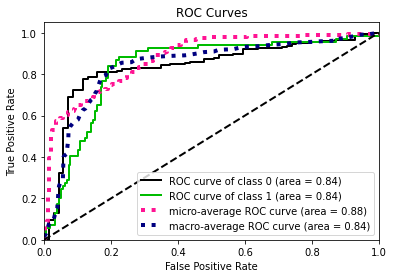

In [517]:
# check ROC-AUC curve and result
skplt.metrics.plot_roc(y_test_churn, pred_proba_result);

In [518]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test_churn, pred_proba_result[:,1])
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)
print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)


Best Threshold=0.2453823038413854, G-Mean=0.8278848098781414


## log reg accuracy

In [519]:
# change predict proba result to optimized one using new threshold
new_pred_result = (pred_proba_result[:,1] >= thresholds[ix]).astype(int)
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, new_pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.945205   0.603960  0.805668    0.774583      0.849878
recall       0.775281   0.884058  0.805668    0.829669      0.805668
f1-score     0.851852   0.717647  0.805668    0.784749      0.814361
support    178.000000  69.000000  0.805668  247.000000    247.000000

Using G-means method, we improve the accuracy of the model from 0.76 to 0.80, and F1-score from 0.55 to 0.71. We set this Logreg model as best model for comparison with more complex model

## KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [520]:
knn = KNeighborsClassifier()
k_range = [2,3,4,5]
param_grid = dict(n_neighbors=k_range, p=[1,2])
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_churn_scl, y_train_churn)
print('Best Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best Score: 0.34075951810517996
Best Hyperparameters: {'n_neighbors': 3, 'p': 1}


In [521]:
best_knn = KNeighborsClassifier(n_neighbors = 3, p= 1)
best_knn.fit(X_train_churn_scl, y_train_churn)

KNeighborsClassifier(n_neighbors=3, p=1)

In [522]:
# predict
pred_result = best_knn.predict(X_test_churn_scl)
pred_proba_result = best_knn.predict_proba(X_test_churn_scl)

In [523]:
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.734375   0.327273  0.643725    0.530824      0.620650
recall       0.792135   0.260870  0.643725    0.526502      0.643725
f1-score     0.762162   0.290323  0.643725    0.526242      0.630353
support    178.000000  69.000000  0.643725  247.000000    247.000000

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



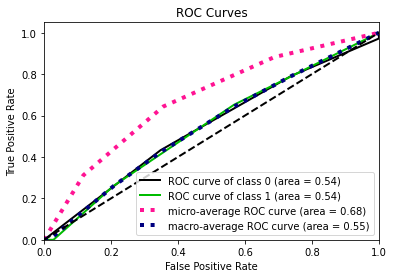

In [524]:
skplt.metrics.plot_roc_curve(y_test_churn, pred_proba_result);

In [525]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test_churn, pred_proba_result[:,1])
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)
print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)


Best Threshold=0.3333333333333333, G-Mean=0.5311498619665852


In [526]:
# change predict proba result to optimized one using new threshold
new_pred_result = (pred_proba_result[:,1] >= thresholds[ix]).astype(int)
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, new_pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.762376   0.308219  0.493927    0.535298      0.635506
recall       0.432584   0.652174  0.493927    0.542379      0.493927
f1-score     0.551971   0.418605  0.493927    0.485288      0.514715
support    178.000000  69.000000  0.493927  247.000000    247.000000

## KNN accuracy

Using G-means method, we did not improve the prediction of KNN. and its performance is worse than LogReg

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [527]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [10, 50,100,1000],
    'max_features': [ 'sqrt', 'log2'],
    'max_depth' : [3,5,10,None],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(X_train_churn_scl, y_train_churn)
print('Best Score: %s' % CV_rfc.best_score_)
print('Best Hyperparameters: %s' % CV_rfc.best_params_)

Best Score: 0.8167574107683
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 1000}


In [528]:
best_rfc = RandomForestClassifier(random_state=42, criterion = "entropy", 
                                  max_depth = None, max_features = "sqrt", n_estimators = 1000)
best_rfc.fit(X_train_churn_scl, y_train_churn)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=1000, random_state=42)

In [529]:
# predict
pred_result = best_rfc.predict(X_test_churn_scl)
pred_proba_result = best_rfc.predict_proba(X_test_churn_scl)

In [530]:
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.810526   0.578947  0.757085    0.694737      0.745834
recall       0.865169   0.478261  0.757085    0.671715      0.757085
f1-score     0.836957   0.523810  0.757085    0.680383      0.749478
support    178.000000  69.000000  0.757085  247.000000    247.000000

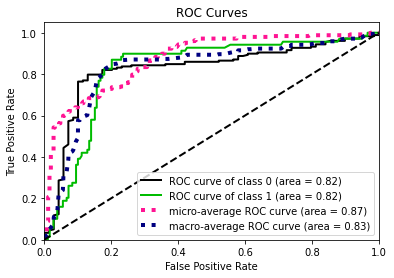

In [531]:
skplt.metrics.plot_roc(y_test_churn, pred_proba_result);

In [532]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test_churn, pred_proba_result[:,1])
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)
print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)


Best Threshold=0.306, G-Mean=0.8328854031454977


## RF accuracy

In [533]:
# change predict proba result to optimized one using new threshold
new_pred_result = (pred_proba_result[:,1] >= thresholds[ix]).astype(int)
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, new_pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.940397   0.625000  0.817814    0.782699      0.852290
recall       0.797753   0.869565  0.817814    0.833659      0.817814
f1-score     0.863222   0.727273  0.817814    0.795247      0.825244
support    178.000000  69.000000  0.817814  247.000000    247.000000

Using G-means method, we improve the accuracy of the model from 0.76 to 0.81, and we F1-score from 0.52 to 0.72. it is better than Random Forest

## XGBoost

In [534]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
param_grid = {'grow_policy':["depthwise", "lossguide"],
              'n_estimators': [10,50,100], 
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth' : [3,5,10,None]}
xgb_cv = GridSearchCV(estimator=xgb, param_grid=param_grid, cv= 10)
xgb_cv.fit(X_train_churn_scl, y_train_churn)
print('Best Score: %s' % xgb_cv.best_score_)
print('Best Hyperparameters: %s' % xgb_cv.best_params_)

Best Score: 0.8325771324863883
Best Hyperparameters: {'grow_policy': 'depthwise', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", l

In [535]:
best_xgb = XGBClassifier(grow_policy = 'depthwise', learning_rate = 0.01, max_depth = 3, n_estimators = 10 )

In [536]:
best_xgb.fit(X_train_churn_scl, y_train_churn)

XGBClassifier(grow_policy='depthwise', learning_rate=0.01, n_estimators=10)

In [537]:
# predict
pred_result = best_xgb.predict(X_test_churn_scl)
pred_proba_result = best_xgb.predict_proba(X_test_churn_scl)

In [538]:
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.894410   0.604651  0.793522    0.749531      0.813465
recall       0.808989   0.753623  0.793522    0.781306      0.793522
f1-score     0.849558   0.670968  0.793522    0.760263      0.799668
support    178.000000  69.000000  0.793522  247.000000    247.000000

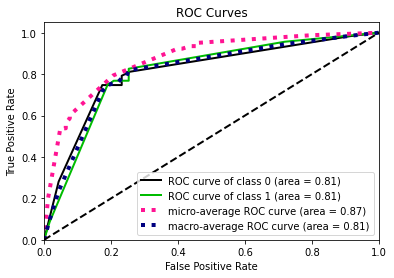

In [539]:
skplt.metrics.plot_roc(y_test_churn, pred_proba_result);

In [540]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test_churn, pred_proba_result[:,1])
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)
print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))
# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))
# find the best threshold
ix = np.argmax(gmeans)


Best Threshold=0.4645549952983856, G-Mean=0.7856492527917981


## xgboost accuracy

In [541]:
# change predict proba result to optimized one using new threshold
new_pred_result = (pred_proba_result[:,1] >= thresholds[ix]).astype(int)
# check classification report result
pd.DataFrame(metrics.classification_report(y_test_churn, new_pred_result, target_names=['not fraud','fraud'], output_dict=True))

not fraud      fraud  accuracy   macro avg  weighted avg
precision    0.917241   0.558824  0.769231    0.738032      0.817117
recall       0.747191   0.826087  0.769231    0.786639      0.769231
f1-score     0.823529   0.666667  0.769231    0.745098      0.779709
support    178.000000  69.000000  0.769231  247.000000    247.000000

Using G-means method, we reduce the perfomance of the model and it has worse perfomance than Random Forest

## Final model selection

Discussion: among the 4 models, Random Forest is the best model with the highest f1-score (0.73) and the highest accuracy (0.81) Therefore, we select Random Forest as our choosen model



# Model Interpretation

In [542]:
## initiate explainer for logreg model
best_rfc_exp = dx.Explainer(best_rfc, X_train_churn_scl, y_train_churn, label = "Xgboost Interpretation")

Preparation of a new explainer is initiated

  -> data              : 574 rows 53 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 574 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Xgboost Interpretation
  -> predict function  : <function yhat_proba_default at 0x7fa995e8b320> will be used (default)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.281, max = 0.938
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.288, mean = 0.00172, max = 0.359
  -> model_info        : package sklearn

A new explainer has been created!


## Feature Importance


In [543]:
# visualizr permutation feature importance for Random Forest Model
model_part = best_rfc_exp.model_parts()

In [435]:
model_part.plot()

## Interpration based on Feature Importance

Based on this feature importance,  incident severity has the most impact on prediction fraud cases. Therefore, the first thing that Bank needs to do is to inspect the incident severity level of any case. More detailed recommendation will depend on our Partial Dependant Plot



## Partial Dependant Plot

In [544]:
# create partial dependence plot of Random Forest model
model_profile = best_rfc_exp.model_profile()

Calculating ceteris paribus: 100%|██████████| 53/53 [03:03<00:00,  3.46s/it]


In [545]:
model_profile.plot()

## Interpretation based on PDP

Recommendation on how to identify potential fraud cases: 

1.  Incident severity . Fraud customers may report their incident in their case with major damage severity level. They may think that if an incident has a major damage, it will increase the chance to get the insurance claim accepted 
2.  Age. Younger customers may submit a fraud insurance claim. this may be based on that young customers dont have a stable income yet, and if they need a big chunk of money, sometimes they will try to lies to insurance company
3.   Chess and Crossfit as hobbies. Somehow, our model think that fraud customers are likely to have chess or crossfit as a hobby. This does not make sense, but we can make this as initial trigger for us to be more careful if customers have Chess or Crossfit as their hobbies
4. Police report yes. those who submit a fraud insurance claim wont take a risk to get caught by filling a police report
5. Number of vehicle involved. those who submit a fraud insurance may say that there is a little number of vehicle involved because the more vehicle involved, the deceitful customers must provide a more convicing lie about how can many cars or vehicle involved
6. Property damaged Yes. those who submit a fraud insurance may say that they have property damaged to increase the chance of their insurance claim being accepted



# no 5 predicting 3 customers using LIME

In [437]:
scaler = RobustScaler()
x_full_scl = scaler.fit_transform(X)
x_full_scl_lime = pd.DataFrame(x_full_scl,columns = scaler.feature_names_in_, index=X.index)

## initialisation

In [548]:
# define Random Forest explainer with lime module
lime_explainer = LimeTabularExplainer(
    X.values,
    feature_names = X.columns.tolist(),
    class_names = ['not_fraud', 'fraud'],
    discretize_continuous = True,
    verbose = True
)

In [549]:
user_id_527945 = X.loc[77]


In [550]:
user_id_235220 = X.loc[97]


In [551]:
user_id_605100 = X.loc[745]


## Interpration user id *527945*

In [552]:
# explain Random Forest prediction for user_id: 527945
lime_explainer.explain_instance(user_id_527945, best_rfc.predict_proba).show_in_notebook(show_table=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Intercept 0.9253844527008599
Prediction_local [0.19163191]
Right: 0.103


this model has a correct prediction because this customer has Total Loss = 1, and if Total Loss = 1 it will decrease the chance of a customer submit a fraud insurance claim

## Interpration user id *235220


*

In [554]:
# explain Random Forest prediction for user_id: 235220
lime_explainer.explain_instance(user_id_235220, best_rfc.predict_proba).show_in_notebook(show_table=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Intercept 0.6632275416133688
Prediction_local [0.20457948]
Right: 0.699


this model has a wrong prediction because this customer has Minor damage = 1, and if Minor damage = 1 , it will decrease the chance of a customer submit a fraud insurance claim, but this model predict that this customer submit a fraud insurance claim

## Interpration user id *605100*

In [555]:
# explain Random Forest prediction for user_id: 605100
lime_explainer.explain_instance(user_id_605100, best_rfc.predict_proba).show_in_notebook(show_table=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Intercept 0.5361504157737533
Prediction_local [0.4628827]
Right: 0.804


this model has a correct prediction because this customer has major damage = 1, and if Major damage = 1 , it will increase the chance of a customer submit a fraud insurance claim, and moreover, this customer does not have camping or gold as hobbies, and based on PDP, if customers do not have these hobbies it will also can increase the probability of them submitting a fraud insurance claim. 